<a href="https://colab.research.google.com/github/ouafighizlene21/Twitter-Disinformation-Study/blob/main/21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📚 Importing Libraries
## 📚 Importation des bibliothèques


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# 📥 Downloading Dataset
## 📥 Téléchargement du jeu de données

In [2]:
!git clone https://github.com/peijoy/DetectDepressionInTwitterPosts.git
df = pd.read_csv('DetectDepressionInTwitterPosts/depressive_tweets_processed.csv')


Cloning into 'DetectDepressionInTwitterPosts'...
remote: Enumerating objects: 44, done.
remote: Total 44 (delta 0), reused 0 (delta 0), pack-reused 44 (from 1)
Receiving objects: 100% (44/44), 446.22 KiB | 18.59 MiB/s, done.
Resolving deltas: 100% (18/18), done.


# 📄 Previewing Dataset Content

## 📄 Aperçu du contenu du jeu de données


In [4]:
with open('DetectDepressionInTwitterPosts/depressive_tweets_processed.csv', 'r', encoding='utf-8') as f:
    for _ in range(10):
        print(f.readline())


989292962323615744|2018-04-25|23:59:57|Eastern Standard Time|whosalli|The lack of this understanding is a small but significant part of what causes anxiety & depression to both feel so incredibly lonely. It's soooo easy to compare. It's so easy to invalidate ourselves because of that.|1|0|3|,,,,,,,,,,,,,,,,,,,,,,,,,

989292959844663296|2018-04-25|23:59:56|Eastern Standard Time|estermnunes|i just told my parents about my depression and it's so hard to get gen x people to understand that this is not something that i can control all the time or just cure with a walk or by keeping my mind busy|1|0|2|,,,,,,,,,,,,,,,,,,,,,,,,,

989292951716155392|2018-04-25|23:59:54|Eastern Standard Time|TheAlphaAries|depression is something i don't speak about even going through it because it's also such a double edged sword. i love every race. even if white people had done so much i can't hate them all. my grandma is legit white! how tf can i hate, i do dislike people though.|0|0|0|,,,,,,,,,,,,,,,,,,,,,,,,

# 📊 Loading Dataset with Custom Parameters

## 📊 Chargement du jeu de données avec paramètres personnalisés


In [5]:
# Lire le fichier avec un nombre de colonnes élevé
df = pd.read_csv(
    'DetectDepressionInTwitterPosts/depressive_tweets_processed.csv',
    sep='|',
    header=None,
    engine='python',
    on_bad_lines='skip',  # Ignore les lignes corrompues
    names=[
        'id', 'date', 'time', 'timezone', 'username',
        'text', 'reply_count', 'retweet_count', 'like_count',
        *['extra_' + str(i) for i in range(25)]  # Pour capturer les NaN/virgules
    ]
)

# Afficher les premières lignes
df.head()


,id,date,time,timezone,username,text,reply_count,retweet_count,like_count,extra_0,...,extra_15,extra_16,extra_17,extra_18,extra_19,extra_20,extra_21,extra_22,extra_23,extra_24
0,989292962323615744,2018-04-25,23:59:57,Eastern Standard Time,whosalli,The lack of this understanding is a small but ...,1,0,3,",,,,,,,,,,,,,,,,,,,,,,,,,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,989292959844663296,2018-04-25,23:59:56,Eastern Standard Time,estermnunes,i just told my parents about my depression and...,1,0,2,",,,,,,,,,,,,,,,,,,,,,,,,,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,989292951716155392,2018-04-25,23:59:54,Eastern Standard Time,TheAlphaAries,depression is something i don't speak about ev...,0,0,0,",,,,,,,,,,,,,,,,,,,,,,,,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,989292873664393218,2018-04-25,23:59:35,Eastern Standard Time,_ojhodgson,Made myself a tortilla filled with pb&j. My de...,1,0,0,",,,,,,,,,,,,,,,,,,,,,,,,,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,989292856119472128,2018-04-25,23:59:31,Eastern Standard Time,DMiller96371630,@WorldofOutlaws I am gonna need depression med...,0,0,0,",,,,,,,,,,,,,,,,,,,,,,,,",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 🧹 Selecting Relevant Columns

## 🧹 Sélection des colonnes pertinentes


In [6]:
# Ne garder que les colonnes importantes
df_clean = df[['id', 'date', 'time', 'timezone', 'username', 'text', 'reply_count', 'retweet_count', 'like_count']]

# Afficher
df_clean.head()


,id,date,time,timezone,username,text,reply_count,retweet_count,like_count
0,989292962323615744,2018-04-25,23:59:57,Eastern Standard Time,whosalli,The lack of this understanding is a small but ...,1,0,3
1,989292959844663296,2018-04-25,23:59:56,Eastern Standard Time,estermnunes,i just told my parents about my depression and...,1,0,2
2,989292951716155392,2018-04-25,23:59:54,Eastern Standard Time,TheAlphaAries,depression is something i don't speak about ev...,0,0,0
3,989292873664393218,2018-04-25,23:59:35,Eastern Standard Time,_ojhodgson,Made myself a tortilla filled with pb&j. My de...,1,0,0
4,989292856119472128,2018-04-25,23:59:31,Eastern Standard Time,DMiller96371630,@WorldofOutlaws I am gonna need depression med...,0,0,0


# 📦 Downloading NLTK Resources
## 📦 Téléchargement des ressources NLTK

In [8]:
# Télécharger les ressources NLTK une seule fois
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# 📝 Initializing Lemmatizer and Stopwords

## 📝 Initialisation du lemmatizer et des stopwords


In [9]:
# Préparer le lemmatizer et les stopwords anglais
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# 🧽 Text Cleaning Function

## 🧽 Fonction de nettoyage du texte


In [10]:
# Fonction de nettoyage
def preprocess_text(text):
    if pd.isna(text):
        return ""

    text = text.lower()  # lowercase
    text = re.sub(r'@\w+', '', text)  # remove mentions
    text = re.sub(r'#\w+', '', text)  # remove hashtags
    text = re.sub(r'http\S+|www\S+', '', text)  # remove URLs
    text = re.sub(r'[^a-z\s]', '', text)  # remove punctuation/numbers
    tokens = text.split()  # tokenize
    tokens = [word for word in tokens if word not in stop_words]  # remove stopwords
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # lemmatize
    return " ".join(tokens)

# ⚙️ Applying Text Preprocessing

## ⚙️ Application du prétraitement du texte


In [11]:
# Appliquer le prétraitement à la colonne 'text'
df['clean_text'] = df['text'].apply(preprocess_text)


# 👀 Displaying Cleaned Text Samples

## 👀 Affichage des échantillons de texte nettoyé


In [12]:
# Afficher les résultats nettoyés
print(df[['clean_text']].head())

                                          clean_text
0  lack understanding small significant part caus...
1  told parent depression hard get gen x people u...
2  depression something dont speak even going als...
3  made tortilla filled pbj depression cured oliv...
4  gonna need depression med soon rainouts spinni...


In [13]:
print(df_clean.columns)


Index(['id', 'date', 'time', 'timezone', 'username', 'text', 'reply_count',
       'retweet_count', 'like_count'],
      dtype='object')


# 📏 Average Tweet Length Analysis

## 📏 Analyse de la longueur moyenne des tweets


In [14]:
# Longueur moyenne des tweets
df['text_length'] = df['clean_text'].apply(len)
print(df['text_length'].describe())

count    3452.000000
mean       88.309676
std        53.221749
min         4.000000
25%        45.000000
50%        75.000000
75%       125.000000
max       377.000000
Name: text_length, dtype: float64


# 📊 General Dataset Statistics

## 📊 Statistiques générales du jeu de données


In [15]:
# Quelques statistiques générales
print("Nombre total de tweets :", len(df))
print("Nombre de mots uniques :", len(set(' '.join(df['clean_text']).split())))


Nombre total de tweets : 3452
Nombre de mots uniques : 8436


# ☁️ Word Cloud Visualization

## ☁️ Visualisation du nuage de mots


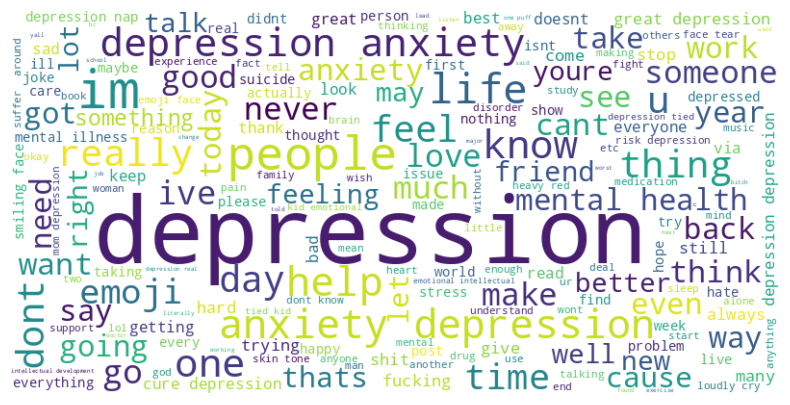

In [16]:
# Nuage de mots (WordCloud)
from wordcloud import WordCloud
import matplotlib.pyplot as plt

text_corpus = ' '.join(df['clean_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_corpus)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 📈 Sentiment Analysis (Polarity & Subjectivity)

## 📈 Analyse de sentiment (Polarité & Subjectivité)


In [17]:
from textblob import TextBlob

# Analyse de polarité et subjectivité
df['polarity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.polarity)
df['subjectivity'] = df['clean_text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

print(df[['clean_text', 'polarity', 'subjectivity']].head())


                                          clean_text  polarity  subjectivity
0  lack understanding small significant part caus...  0.178333      0.728333
1  told parent depression hard get gen x people u... -0.095833      0.420833
2  depression something dont speak even going als... -0.128571      0.371429
3  made tortilla filled pbj depression cured oliv...  0.400000      0.900000
4  gonna need depression med soon rainouts spinni... -0.312500      0.687500


# 📊 Polarity Distribution Visualization

## 📊 Visualisation de la distribution de la polarité


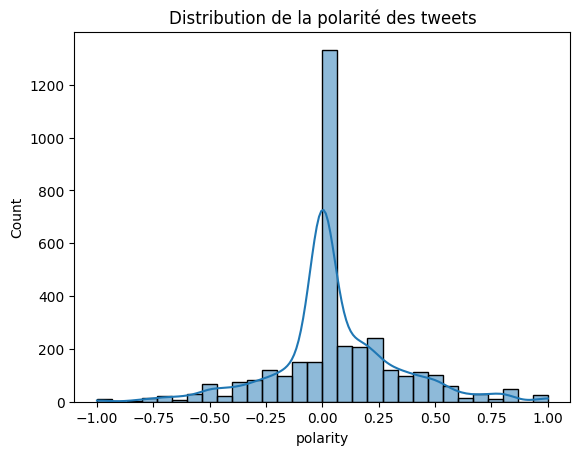

In [ ]:
import seaborn as sns

sns.histplot(df['polarity'], bins=30, kde=True)
plt.title("Distribution de la polarité des tweets")
plt.show()


# 🏷️ Binary Sentiment Categorization

## 🏷️ Catégorisation binaire du sentiment


In [18]:
# Exemple de catégorisation binaire
df['sentiment'] = df['polarity'].apply(lambda x: 'positif' if x > 0 else ('négatif' if x < 0 else 'neutre'))


In [19]:
print("Nombre de tweets :", len(df))


Nombre de tweets : 3452


# 🔠 Most Frequent Words Analysis

## 🔠 Analyse des mots les plus fréquents


In [20]:
from collections import Counter
import nltk
nltk.download('punkt')

all_words = ' '.join(df['clean_text']).split()
word_freq = Counter(all_words)

print(word_freq.most_common(20))  # 20 mots les plus fréquents


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


[('depression', 3199), ('anxiety', 475), ('im', 392), ('like', 308), ('emoji', 286), ('people', 259), ('dont', 245), ('face', 240), ('get', 224), ('help', 221), ('one', 208), ('know', 205), ('life', 199), ('feel', 167), ('mental', 166), ('time', 163), ('day', 162), ('u', 162), ('thing', 154), ('really', 151)]


# 🏷️ Creating Sentiment Labels from Polarity
## 🏷️ Création d'étiquettes de sentiment à partir de la polarité

In [21]:
def get_label(polarity):
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"

df['label'] = df['polarity'].apply(get_label)
df[['clean_text', 'polarity', 'label']].head()


,clean_text,polarity,label
0,lack understanding small significant part caus...,0.178333,positive
1,told parent depression hard get gen x people u...,-0.095833,negative
2,depression something dont speak even going als...,-0.128571,negative
3,made tortilla filled pbj depression cured oliv...,0.400000,positive
4,gonna need depression med soon rainouts spinni...,-0.312500,negative


# 🔢 Label Encoding
## 🔢 Encodage des étiquettes


In [22]:

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
df['label_encoded'] = encoder.fit_transform(df['label'])


# 🔀 Train/Test Split
## 🔀 Séparation des données en entraînement et test


In [23]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    df['clean_text'],
    df['label_encoded'],
    test_size=0.2,
    random_state=42
)


# 🧮 TF-IDF Vectorization
## 🧮 Vectorisation TF-IDF

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)


# 🤖 Model Training - Logistic Regression
## 🤖 Entraînement du modèle - Régression logistique


In [26]:

from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=200)

# 📊 Model Evaluation
## 📊 Évaluation du modèle

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred, target_names=encoder.classes_))
print(confusion_matrix(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.88      0.51      0.65       185
     neutral       0.79      0.77      0.78       232
    positive       0.69      0.89      0.78       274

    accuracy                           0.75       691
   macro avg       0.78      0.73      0.74       691
weighted avg       0.77      0.75      0.74       691

[[ 95  27  63]
 [  6 179  47]
 [  7  22 245]]


# 📝 Custom Prediction Test
## 📝 Test de prédiction personnalisée


In [28]:

sample_text = ["I feel so sad and hopeless today",
               "What a wonderful day full of joy!",
               "It's just an ordinary day"]
sample_vector = vectorizer.transform(sample_text)
predictions = model.predict(sample_vector)

for text, label_code in zip(sample_text, predictions):
    print(f"Tweet: {text} -> Predicted Sentiment: {encoder.inverse_transform([label_code])[0]}")


Tweet: I feel so sad and hopeless today -> Predicted Sentiment: negative
Tweet: What a wonderful day full of joy! -> Predicted Sentiment: positive
Tweet: It's just an ordinary day -> Predicted Sentiment: positive


# 💾 Saving Model and Vectorizer
## 💾 Sauvegarde du modèle et du vectoriseur

In [29]:
import joblib

joblib.dump(model, "sentiment_model.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")
joblib.dump(encoder, "label_encoder.pkl")


['label_encoder.pkl']

In [43]:
from google.colab import files

files.download("sentiment_model.pkl")
files.download("tfidf_vectorizer.pkl")
files.download("label_encoder.pkl")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>